In [1]:
%reload_ext swagpy.jupyter
from pathlib import Path

import numpy as np
import pandas as pd
import xarray as xr

from sklearn.naive_bayes import GaussianNB
import tensorflow as tf

from swagpy.constants import STORE, PROBSEVERE as PS, GMGSI


print(
    [
        tf.config.experimental.get_device_details(gpu)
        for gpu in tf.config.list_physical_devices("GPU")
    ]
)

2022-10-08 12:22:53.288254: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-08 12:22:54.011295: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-08 12:22:55.227740: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-10-08 12:22:55.228015: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinf

[{'compute_capability': (7, 5), 'device_name': 'NVIDIA GeForce RTX 2080 SUPER'}]


2022-10-08 12:22:56.399785: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-10-08 12:22:56.495457: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-10-08 12:22:56.495526: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-10-08 12:22:56.496000: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [2]:
features = (
    PS.load()
    .to_dataframe()
    .rename(columns={"MINX": "minx", "MINY": "miny", "MAXX": "maxx", "MAXY": "maxy"})
)
features

,CAPE_M10M30,EBSHEAR,FLASH_DENSITY,FLASH_RATE,ID,LJA,MAXLLAZ,maxx,maxy,MEANWIND_1-3kmAGL,MESH,minx,miny,MLCAPE,MLCIN,MOTION_EAST,MOTION_SOUTH,MUCAPE,P98LLAZ,P98MLAZ,PS,PWAT,SIZE,SRH01KM,VIL_DENSITY,WETBULB_0C_HGT,X,Y
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-09-01 00:00:40,144,31.100000,0.00,0,124878,0.0,0.002,-69.629997,48.669998,18.5,0.07,-69.769997,48.470001,380,-15,0.048,-0.806,525,0.002,0.002,3,0.9,208,0,0.82,6.6,48.570000,-69.695000
2022-09-01 00:00:40,830,10.900000,1.08,7,125020,0.0,0.002,-92.029999,32.250000,8.5,0.07,-92.269997,32.099998,2278,-30,-0.857,2.953,3922,0.001,0.001,0,2.1,281,21,0.99,13.4,32.174999,-92.155998
2022-09-01 00:00:40,589,18.700001,0.09,2,125349,0.0,0.005,-85.379997,30.700001,8.8,0.15,-85.470001,30.600000,2466,-21,-0.396,1.905,2757,0.003,0.003,1,2.4,84,61,1.52,14.1,30.670000,-85.432999
2022-09-01 00:00:40,521,13.900000,0.43,11,125402,0.0,0.006,-81.889999,26.900000,4.7,0.24,-82.010002,26.690001,2640,-4,-3.248,0.508,3427,0.004,0.003,1,2.5,167,9,1.49,13.6,26.790001,-81.949997
2022-09-01 00:00:40,167,12.000000,0.31,7,125522,0.0,0.004,-107.199997,36.500000,8.6,0.49,-107.389999,36.360001,396,-11,-3.266,2.576,753,0.002,0.003,1,0.9,218,18,1.95,8.9,36.439999,-107.294998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-01 23:58:39,620,22.299999,0.00,0,136679,0.0,0.000,-86.110001,29.080000,8.1,0.00,-86.209999,28.990000,2619,-4,-1.998,-4.066,3307,0.000,0.000,1,2.1,70,15,0.33,14.5,29.035000,-86.161247
2022-09-01 23:58:39,672,21.600000,0.00,0,136680,0.0,0.001,-86.599998,28.820000,6.8,0.00,-86.699997,28.740000,2831,-2,-0.096,-4.352,3848,0.001,0.001,1,2.2,56,4,0.41,14.5,28.785000,-86.669167
2022-09-01 23:58:39,632,4.100000,0.00,0,136681,0.0,0.000,-78.050003,25.830000,2.4,0.19,-78.139999,25.740000,2233,-1,-4.922,-0.034,3469,0.000,0.000,0,1.8,68,0,1.05,13.5,25.785000,-78.093750


In [3]:
gmgsi = GMGSI.load()
gmgsi

<xarray.Dataset>
Dimensions:    (time: 2, lat: 3000, lon: 4999)
Coordinates:
  * lat        (lat) float32 -72.74 -72.72 -72.69 -72.67 ... 72.67 72.69 72.72
  * lon        (lon) float32 -179.9 -179.9 -179.8 -179.7 ... 179.8 179.9 180.0
  * time       (time) datetime64[ns] 2022-09-01 2022-09-01T01:00:00
Data variables:
    GMGSI_LW   (time, lat, lon) float32 dask.array<chunksize=(1, 3000, 4999), meta=np.ndarray>
    GMGSI_SSR  (time, lat, lon) float32 dask.array<chunksize=(1, 3000, 4999), meta=np.ndarray>
    GMGSI_SW   (time, lat, lon) float32 dask.array<chunksize=(1, 3000, 4999), meta=np.ndarray>
    GMGSI_VIS  (time, lat, lon) float32 dask.array<chunksize=(1, 3000, 4999), meta=np.ndarray>
    GMGSI_WV   (time, lat, lon) float32 dask.array<chunksize=(1, 3000, 4999), meta=np.ndarray>
Attributes:
    Conventions:          CF-1.4
    NCO:                  netCDF Operators version 4.7.5 (Homepage = http://n...
    Satellite Sensor:     DERIVED DATA
    Source:               McIDAS Area File
    history:              Thu Sep  1 00:34:25 2022: ncks -d xc,0,4998 tempo.n...
    instrument_name:      GLOBCOMPWV
    time_coverage_start:  2022-09-01T00:00:00

In [10]:
from typing import Generic, NewType, TypeVar
from gswp.constants import MRMS_BOUNDS


W, E, S, N = MRMS_BOUNDS
_1D = NewType("1d", tuple)
_2D = NewType("2d", tuple)


def load_and_filter(dtype=np.float32) -> pd.DataFrame:
    gmgsi = GMGSI.load()
    lat, lon = gmgsi["lat"].to_numpy(), gmgsi["lon"].to_numpy()
    lat = lat[(lat > S) & (lat < N)]
    lon = lon[(lon > W) & (lon < E)]
    return (
        gmgsi.sel({"lat": lat, "lon": lon})
        .drop(["GMGSI_SSR", "GMGSI_VIS"])
        .to_dataframe()
        .reset_index(["lat", "lon"])
        .astype(dtype=dtype)
    )


def min_diff(
    target: np.ndarray[_1D, np.floating], values: np.ndarray[_1D, np.floating]
) -> np.ndarray[_1D, np.unsignedinteger]:
    diff = abs(target[:, np.newaxis] - values)
    index = np.argmin(diff, axis=0)
    return index


gmgsi = load_and_filter()
lat, lon = (np.unique(gmgsi[crd]) for crd in ("lat", "lon"))
gmgsi

,lat,lon,GMGSI_LW,GMGSI_SW,GMGSI_WV
time,,,,,
2022-09-01 00:00:00,20.029663,-129.954163,72.0,84.0,137.0
2022-09-01 00:00:00,20.029663,-129.882156,73.0,84.0,137.0
2022-09-01 00:00:00,20.029663,-129.810150,72.0,84.0,137.0
2022-09-01 00:00:00,20.029663,-129.738129,73.0,84.0,135.0
2022-09-01 00:00:00,20.029663,-129.666122,72.0,85.0,135.0
...,...,...,...,...,...
2022-09-01 01:00:00,54.983643,-60.321495,185.0,190.0,199.0
2022-09-01 01:00:00,54.983643,-60.249489,183.0,186.0,199.0
2022-09-01 01:00:00,54.983643,-60.177479,185.0,189.0,199.0


In [11]:
min_lon = min_diff(lon, features.minx.to_numpy())
max_lon = min_diff(lon, features.maxx.to_numpy())
min_lat = min_diff(lat, features.miny.to_numpy())
max_lat = min_diff(lat, features.maxy.to_numpy())

In [27]:
# NOTE:  NOT CORRECT!!! the times are not aligned
data = gmgsi.set_index(["lat", "lon"], append=True).unstack("lon")


def extract(arr):
    return [
        arr[..., x1:x2, y1:y2]
        for x1, x2, y1, y2 in np.c_[min_lat, max_lat, min_lon, max_lon]
    ]


arr = np.array(
    [
        data["GMGSI_LW"].to_numpy(),
        data["GMGSI_SW"].to_numpy(),
        data["GMGSI_WV"].to_numpy(),
    ]
)


features["observations"] = extract(arr)


features

,CAPE_M10M30,EBSHEAR,FLASH_DENSITY,FLASH_RATE,ID,LJA,MAXLLAZ,maxx,maxy,MEANWIND_1-3kmAGL,MESH,minx,miny,MLCAPE,MLCIN,MOTION_EAST,MOTION_SOUTH,MUCAPE,P98LLAZ,P98MLAZ,PS,PWAT,SIZE,SRH01KM,VIL_DENSITY,WETBULB_0C_HGT,X,Y,observations
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-09-01 00:00:40,144,31.100000,0.00,0,124878,0.0,0.002,-69.629997,48.669998,18.5,0.07,-69.769997,48.470001,380,-15,0.048,-0.806,525,0.002,0.002,3,0.9,208,0,0.82,6.6,48.570000,-69.695000,"[[[110.0, 111.0], [110.0, 109.0], [110.0, 109...."
2022-09-01 00:00:40,830,10.900000,1.08,7,125020,0.0,0.002,-92.029999,32.250000,8.5,0.07,-92.269997,32.099998,2278,-30,-0.857,2.953,3922,0.001,0.001,0,2.1,281,21,0.99,13.4,32.174999,-92.155998,"[[[120.0, 121.0, 119.0, 119.0], [120.0, 121.0,..."
2022-09-01 00:00:40,589,18.700001,0.09,2,125349,0.0,0.005,-85.379997,30.700001,8.8,0.15,-85.470001,30.600000,2466,-21,-0.396,1.905,2757,0.003,0.003,1,2.4,84,61,1.52,14.1,30.670000,-85.432999,"[[[93.0]], [[105.0]], [[168.0]]]"
2022-09-01 00:00:40,521,13.900000,0.43,11,125402,0.0,0.006,-81.889999,26.900000,4.7,0.24,-82.010002,26.690001,2640,-4,-3.248,0.508,3427,0.004,0.003,1,2.5,167,9,1.49,13.6,26.790001,-81.949997,"[[[87.0], [86.0], [87.0]], [[101.0], [100.0], ..."
2022-09-01 00:00:40,167,12.000000,0.31,7,125522,0.0,0.004,-107.199997,36.500000,8.6,0.49,-107.389999,36.360001,396,-11,-3.266,2.576,753,0.002,0.003,1,0.9,218,18,1.95,8.9,36.439999,-107.294998,"[[[149.0, 151.0, 132.0], [154.0, 155.0, 146.0]..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-01 23:58:39,620,22.299999,0.00,0,136679,0.0,0.000,-86.110001,29.080000,8.1,0.00,-86.209999,28.990000,2619,-4,-1.998,-4.066,3307,0.000,0.000,1,2.1,70,15,0.33,14.5,29.035000,-86.161247,"[[[87.0, 86.0]], [[101.0, 101.0]], [[156.0, 15..."
2022-09-01 23:58:39,672,21.600000,0.00,0,136680,0.0,0.001,-86.599998,28.820000,6.8,0.00,-86.699997,28.740000,2831,-2,-0.096,-4.352,3848,0.001,0.001,1,2.2,56,4,0.41,14.5,28.785000,-86.669167,"[[[88.0]], [[102.0]], [[154.0]]]"
2022-09-01 23:58:39,632,4.100000,0.00,0,136681,0.0,0.000,-78.050003,25.830000,2.4,0.19,-78.139999,25.740000,2233,-1,-4.922,-0.034,3469,0.000,0.000,0,1.8,68,0,1.05,13.5,25.785000,-78.093750,"[[[105.0], [104.0]], [[119.0], [118.0]], [[114..."


In [99]:
np.array(
    [
        data["GMGSI_LW"].unstack("lon").to_numpy(),
        data["GMGSI_SW"].unstack("lon").to_numpy(),
        data["GMGSI_WV"].unstack("lon").to_numpy(),
    ]
).shape

(3, 1270, 972)

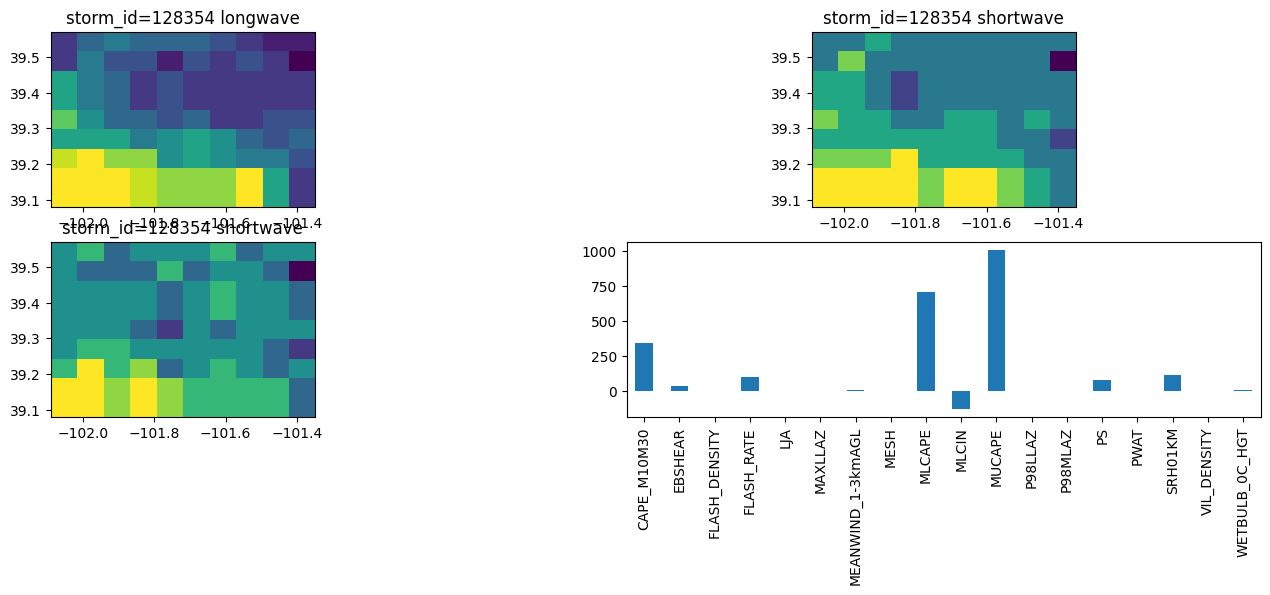

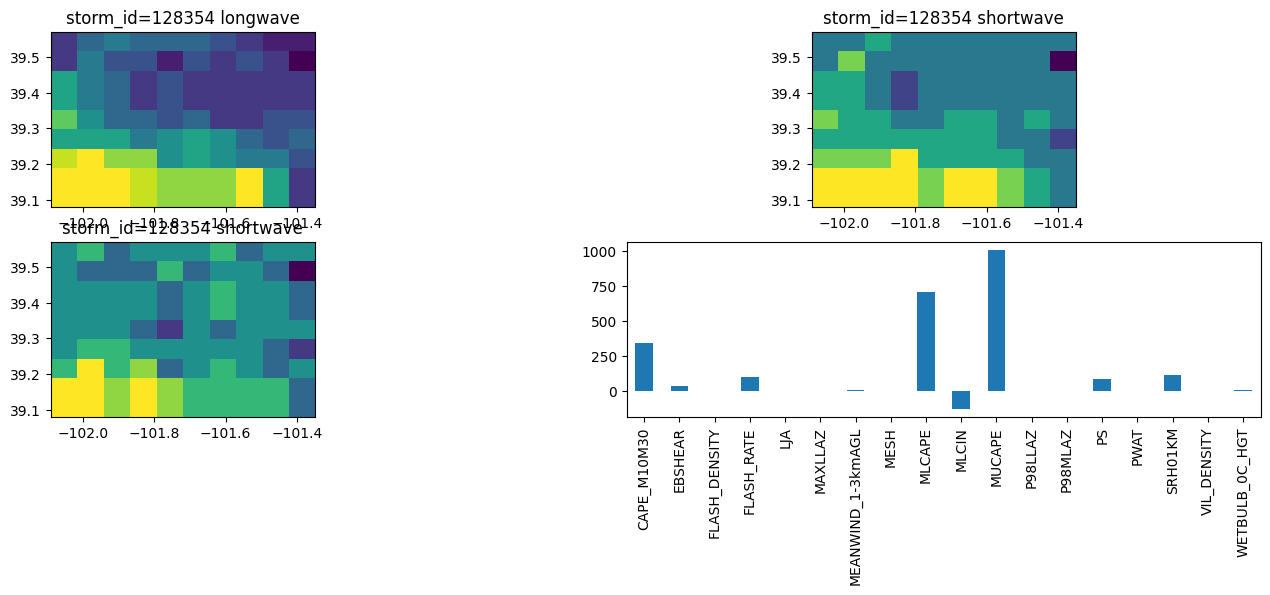

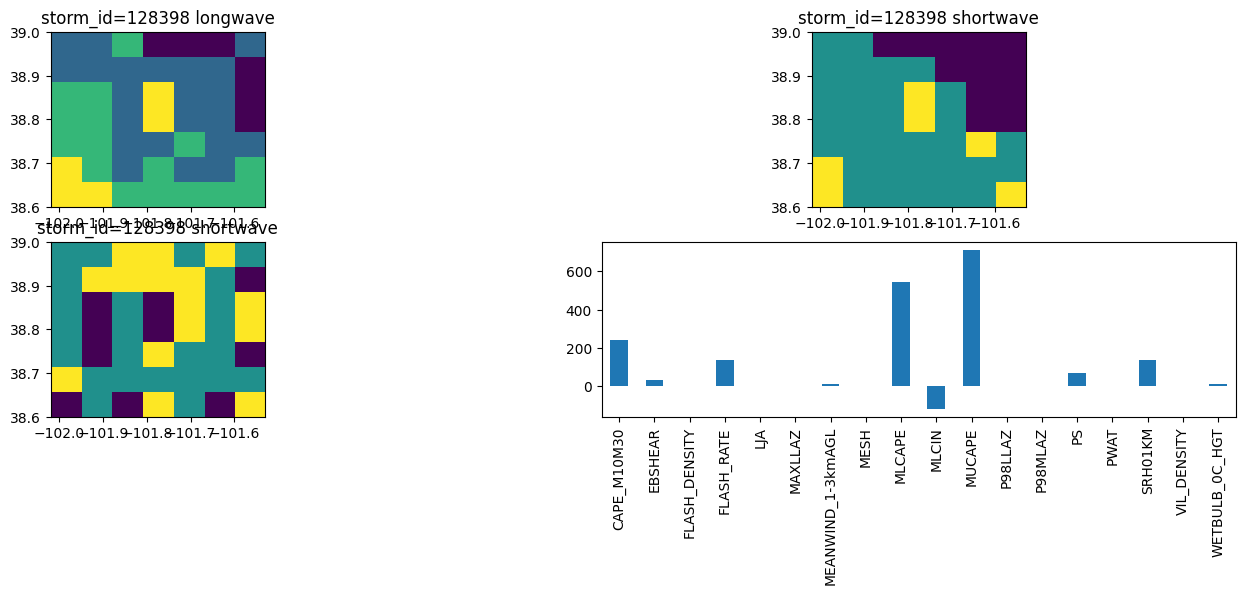

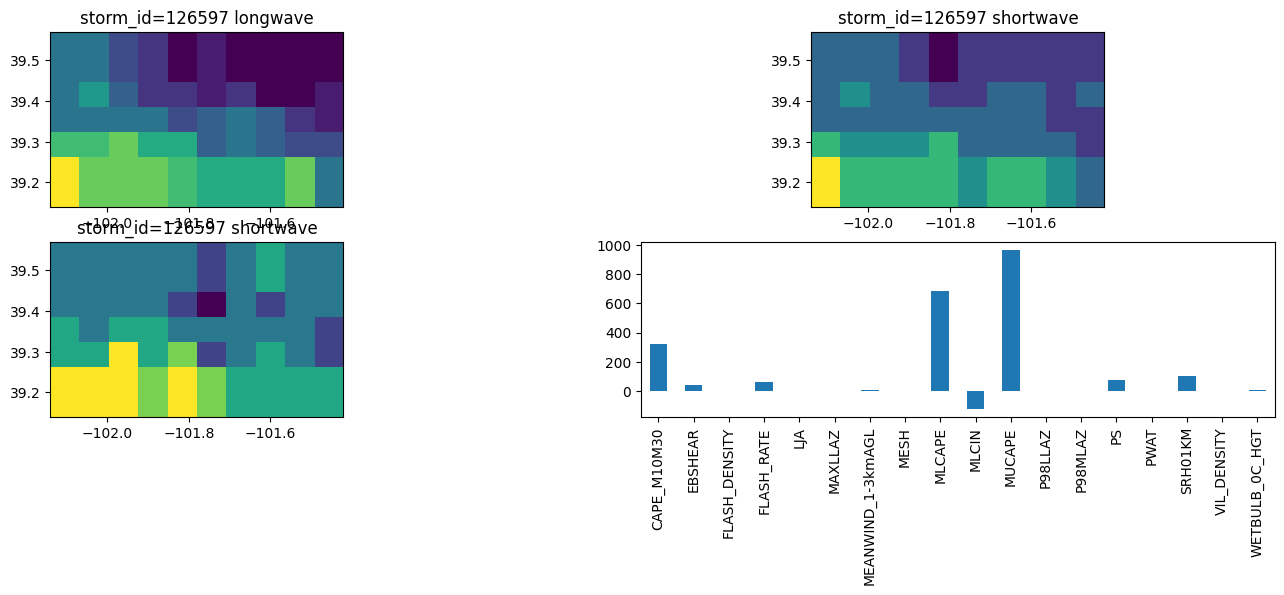

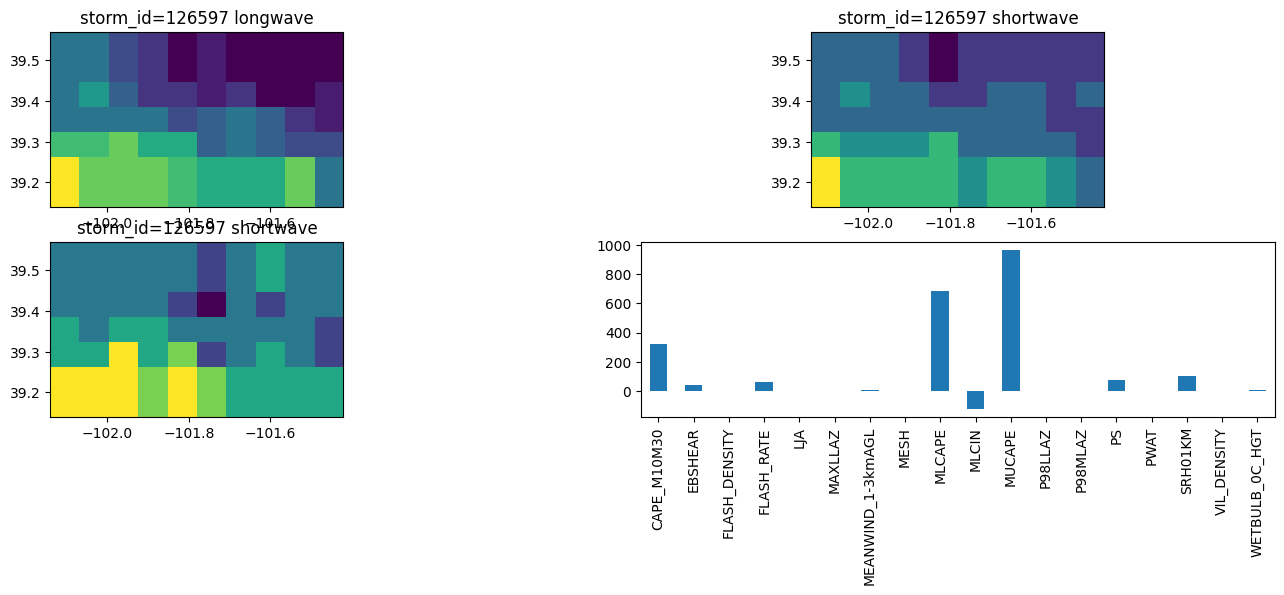

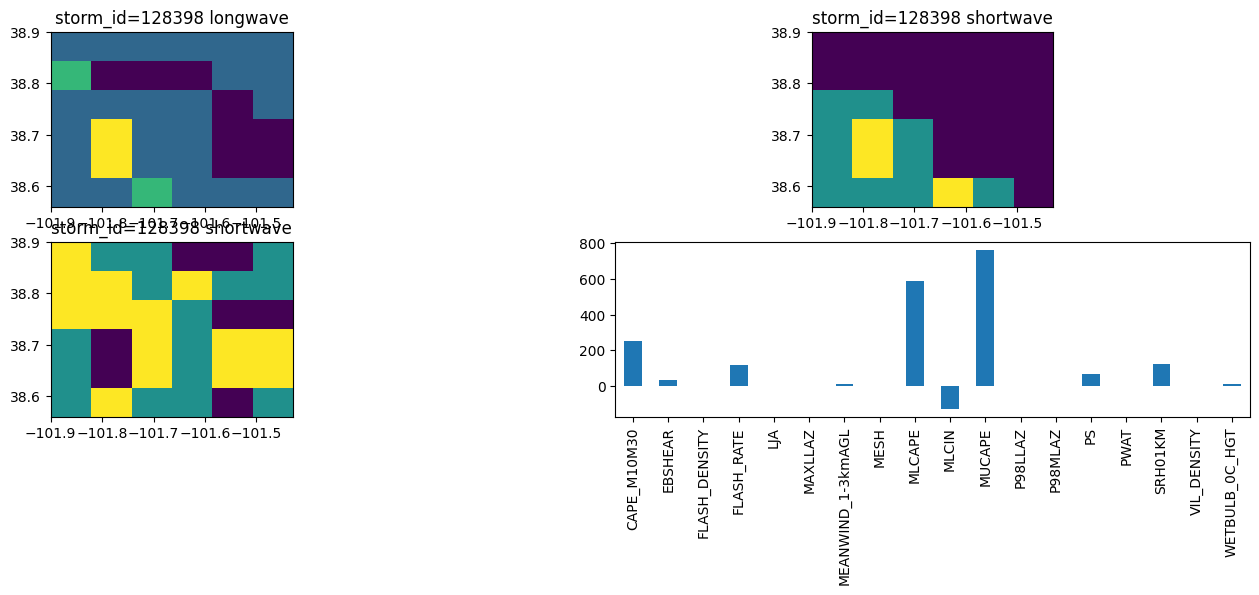

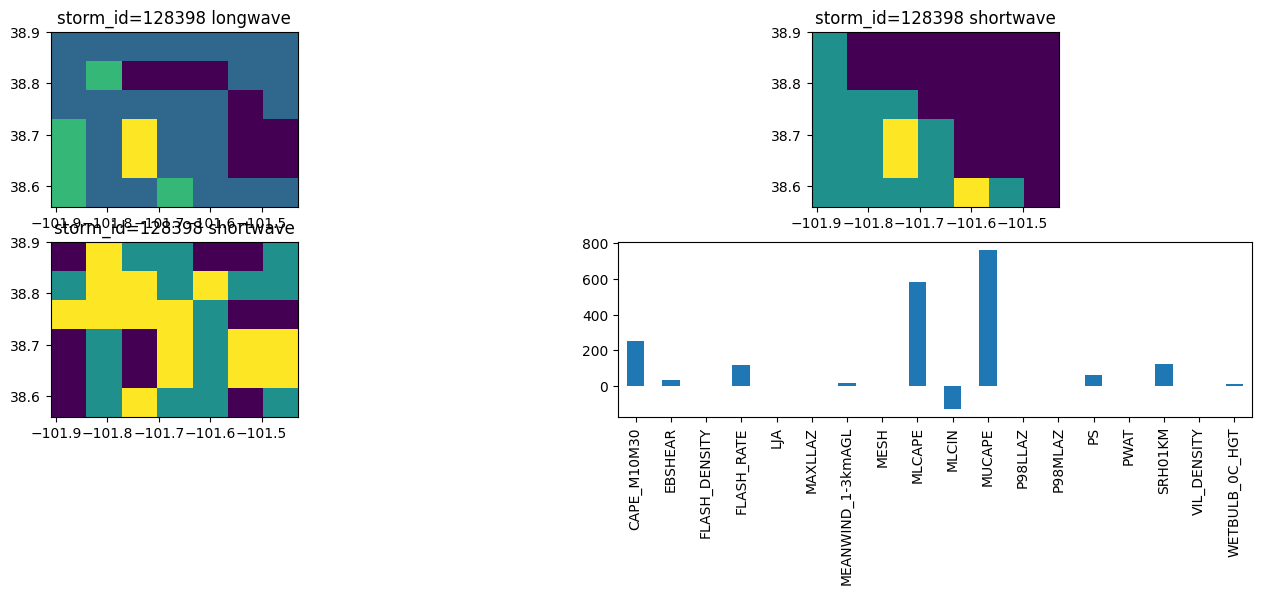

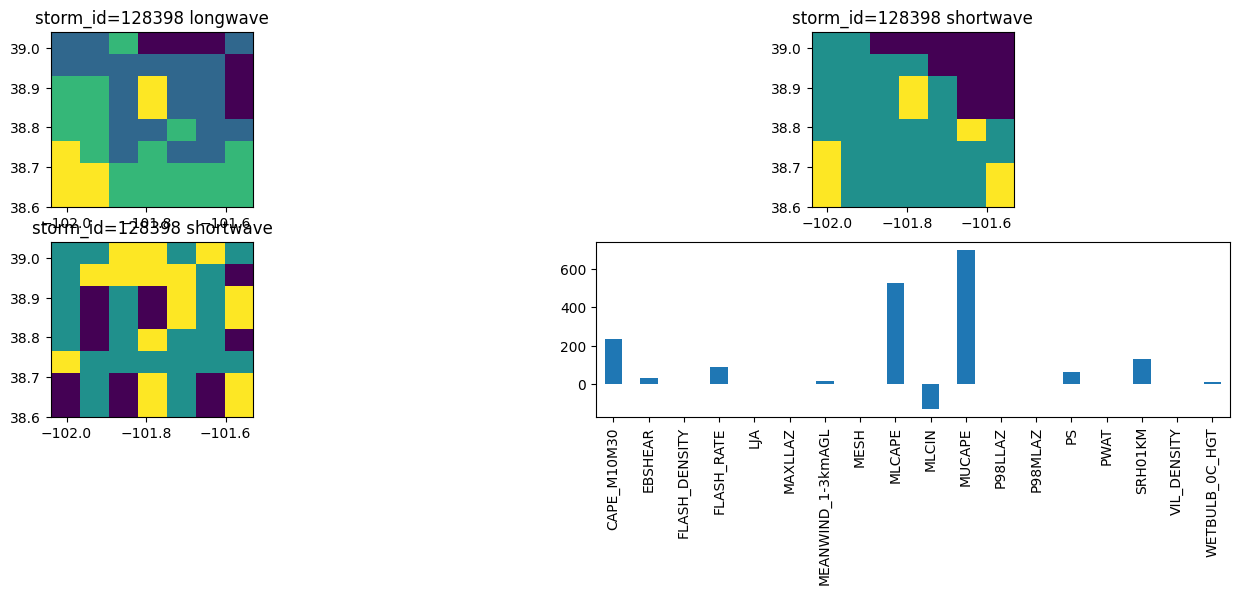

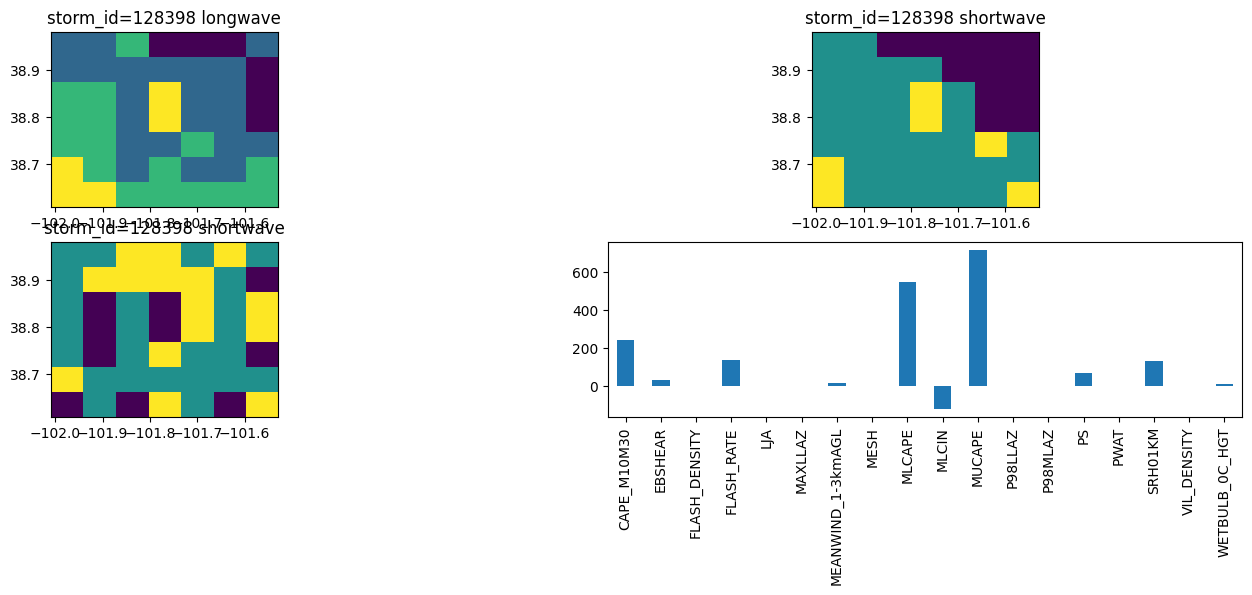

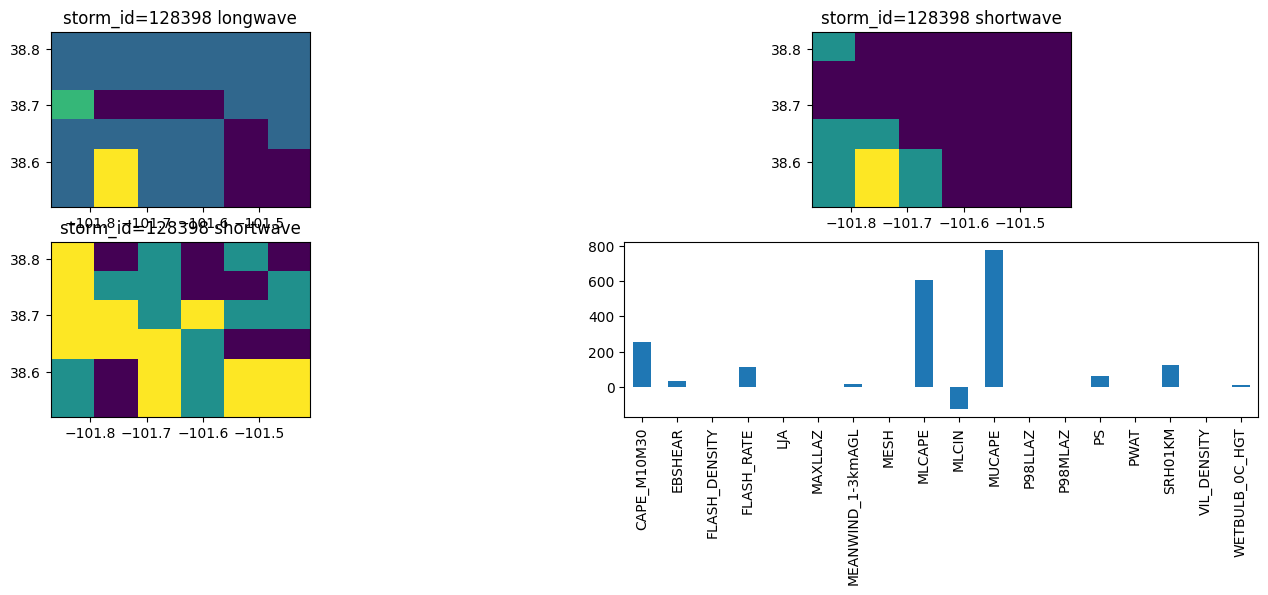

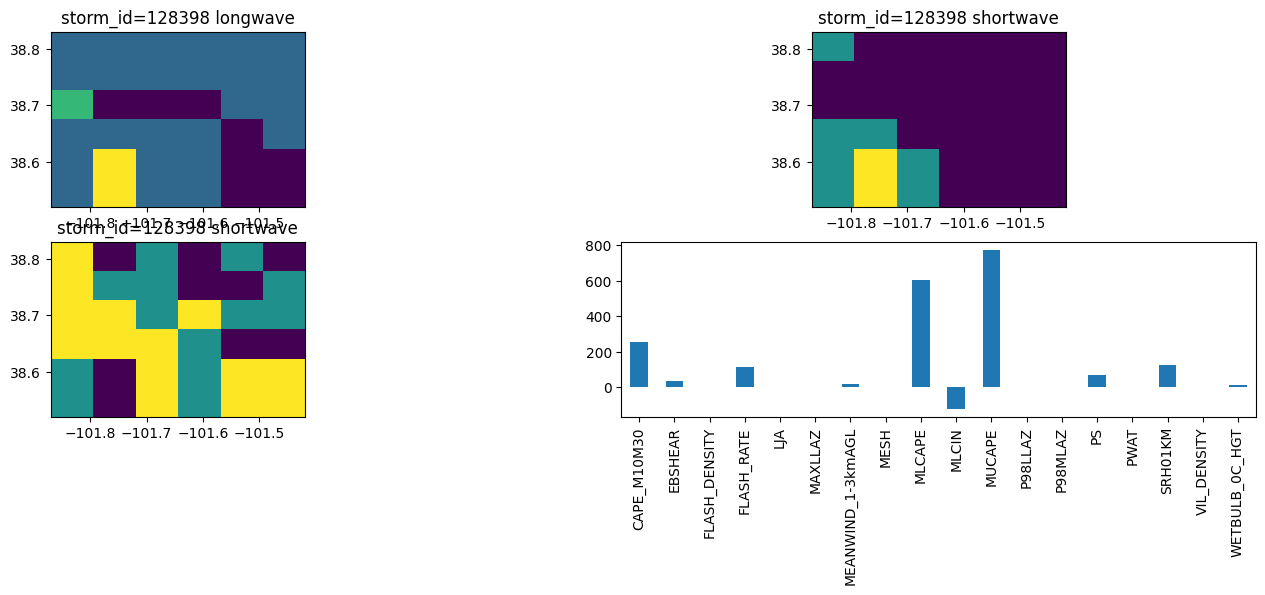

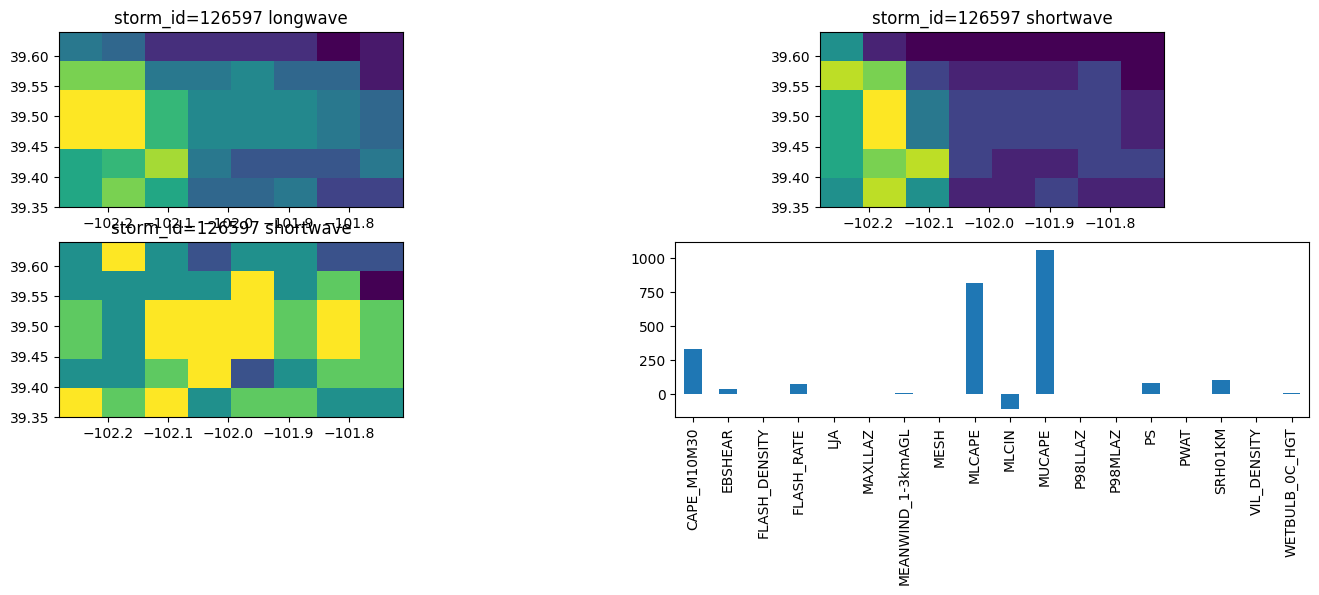

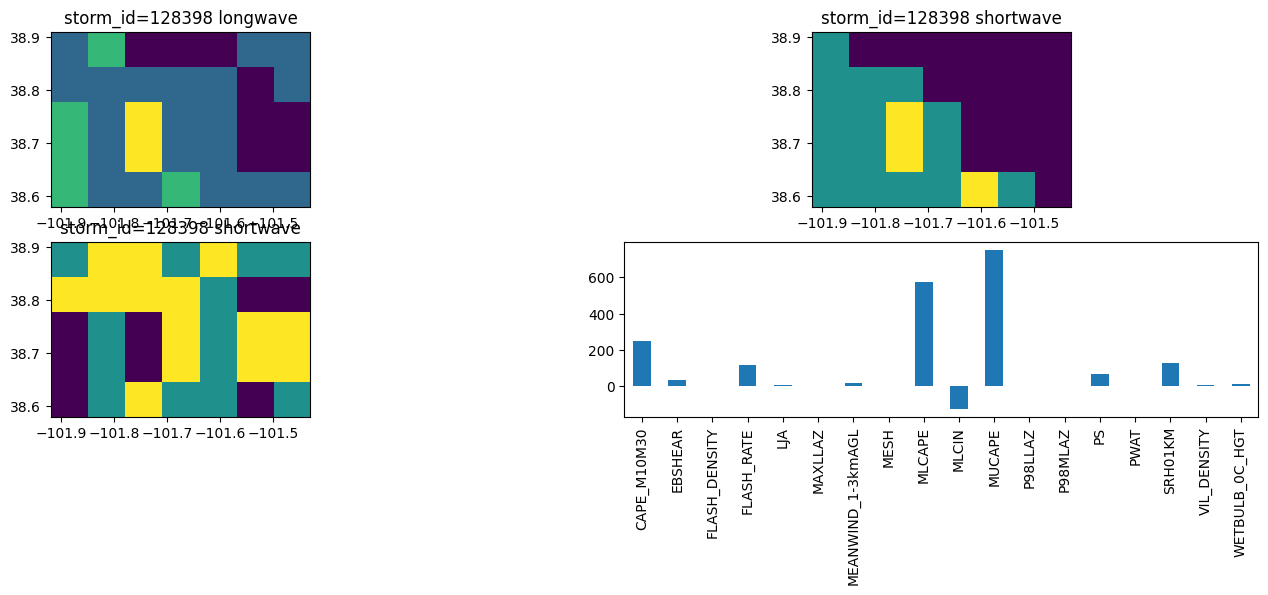

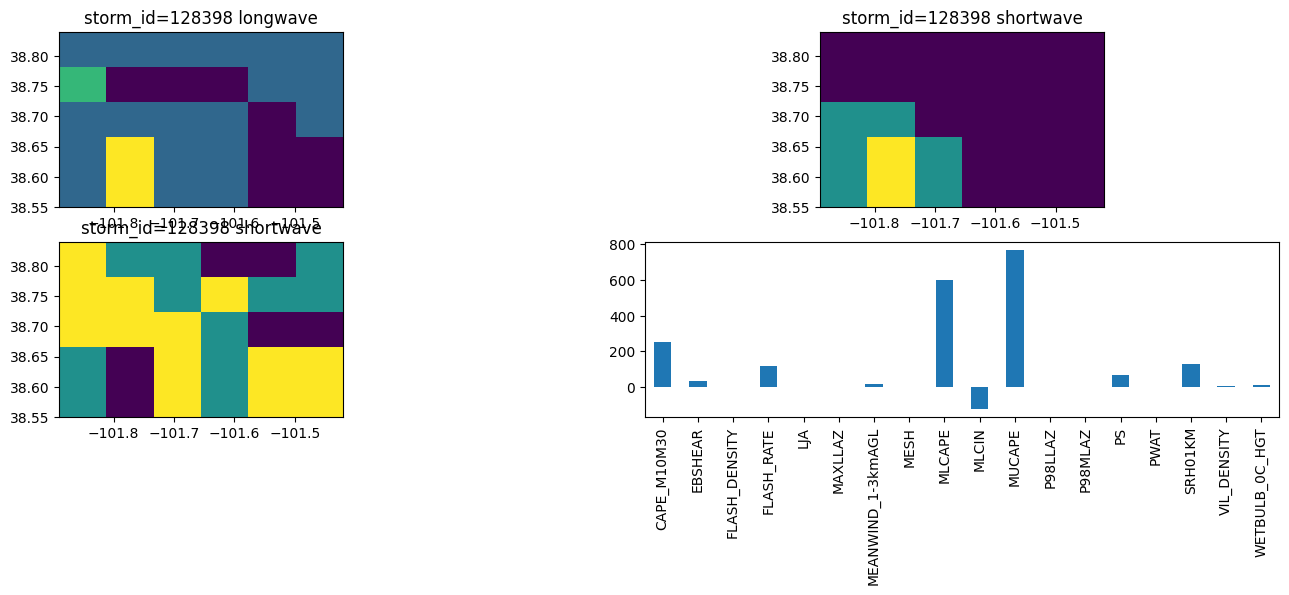

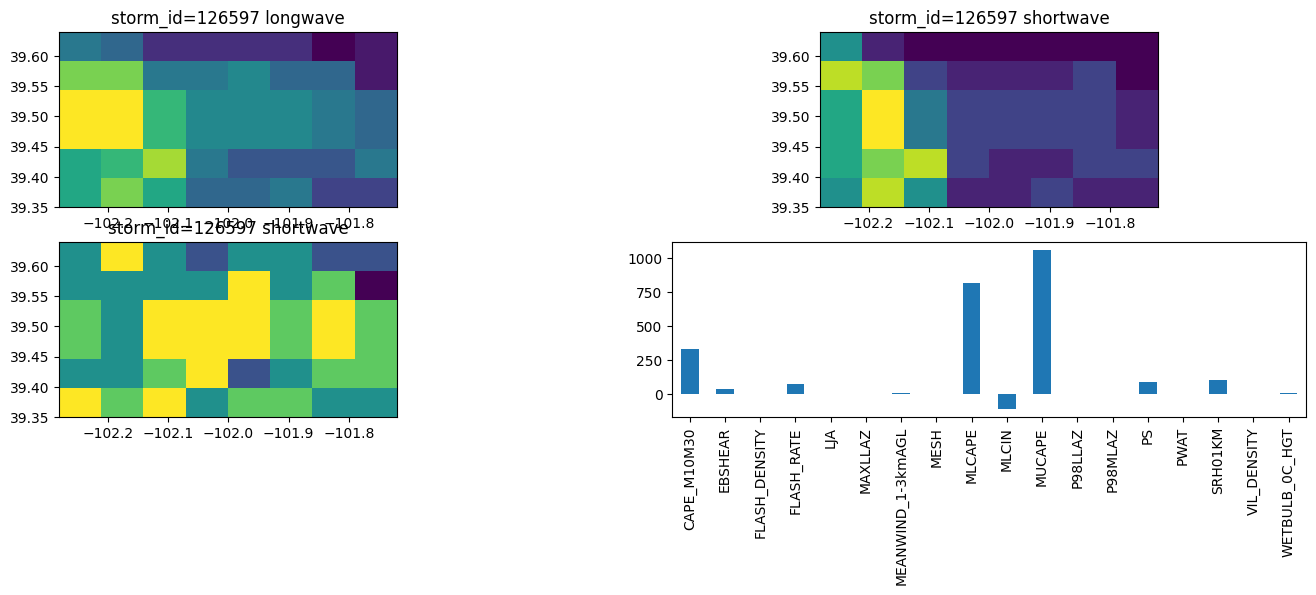

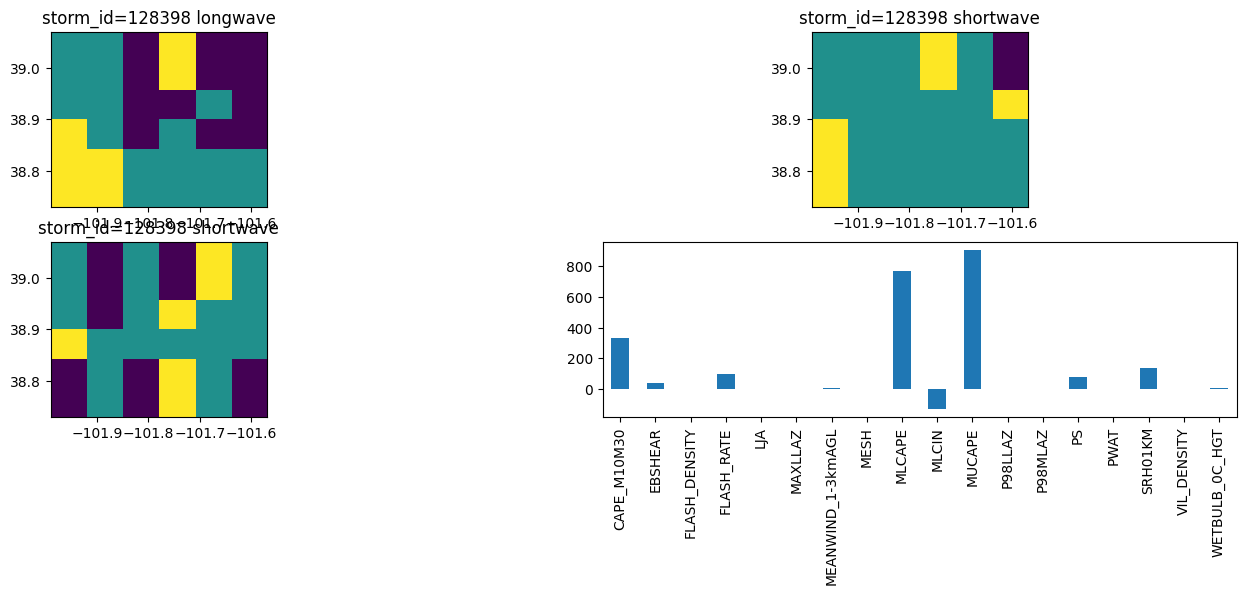

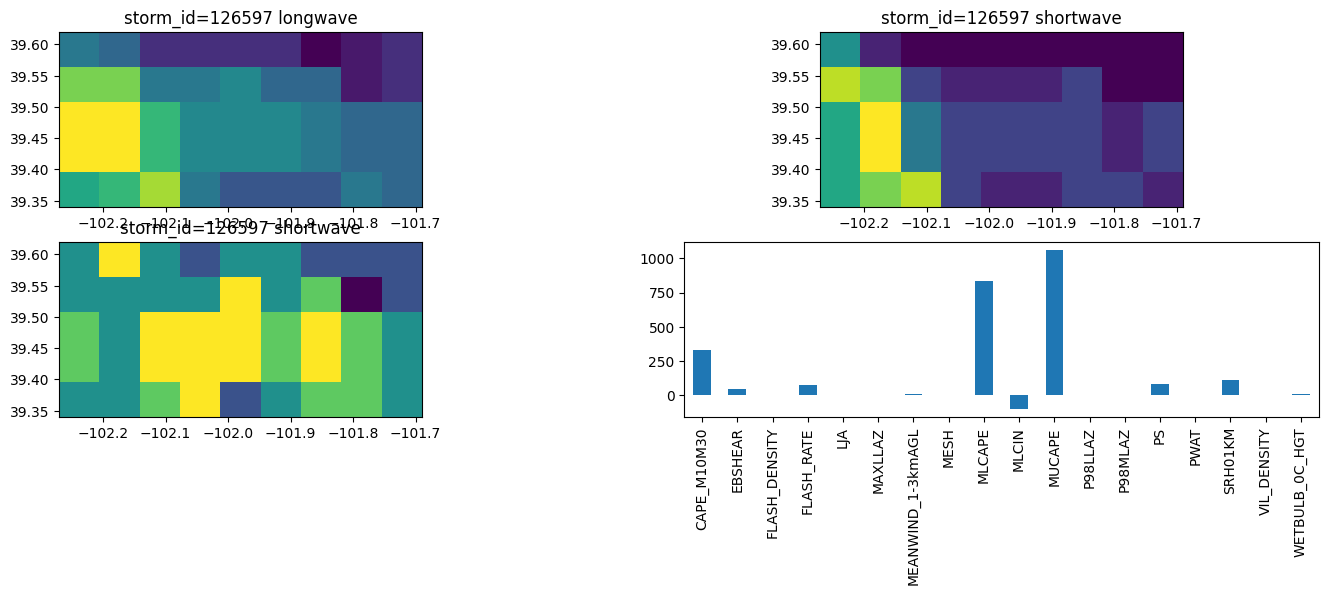

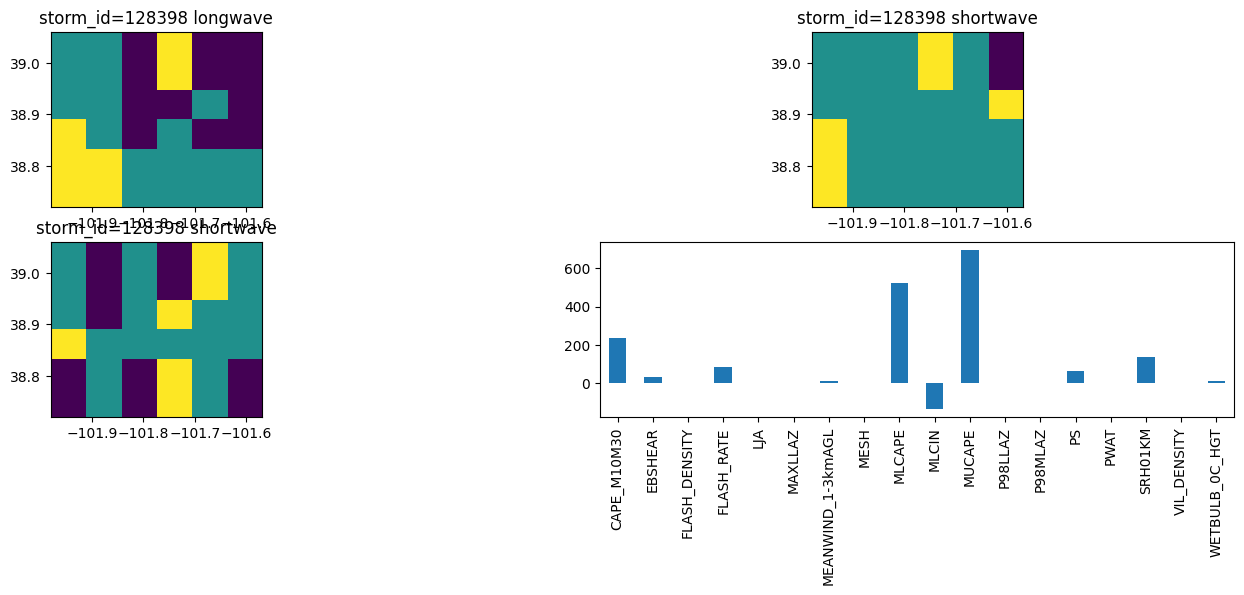

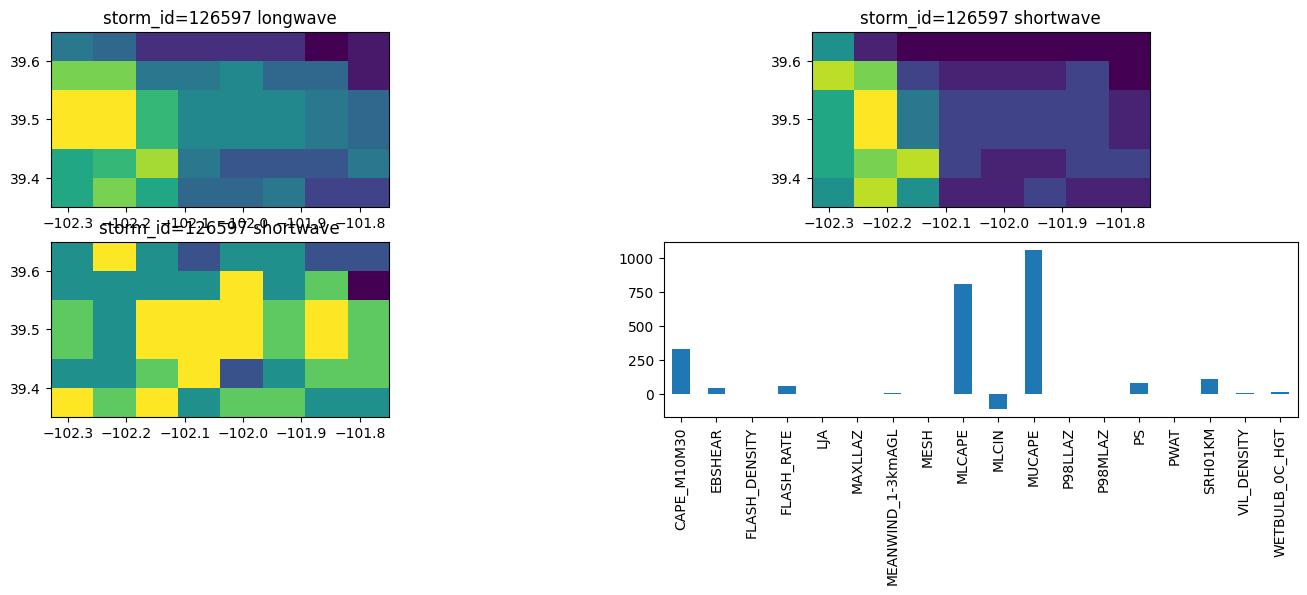

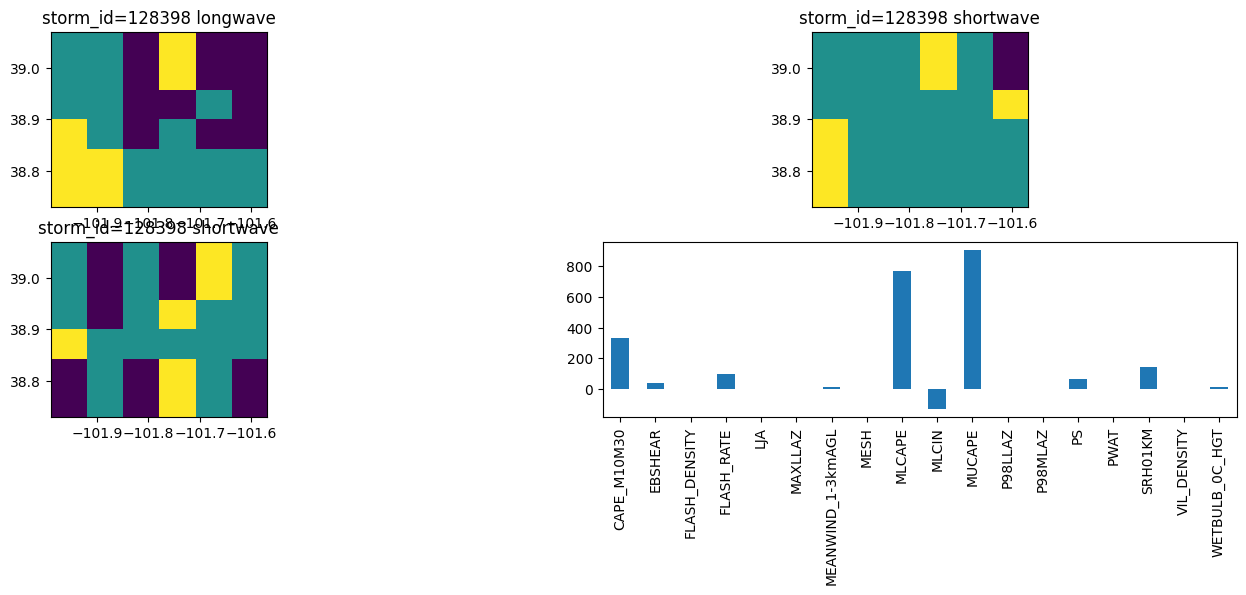

In [79]:
import matplotlib.pyplot as plt

components = [
    "CAPE_M10M30",
    "EBSHEAR",
    "FLASH_DENSITY",
    "FLASH_RATE",
    "LJA",
    "MAXLLAZ",
    "MEANWIND_1-3kmAGL",
    "MESH",
    "MLCAPE",
    "MLCIN",
    "MUCAPE",
    "P98LLAZ",
    "P98MLAZ",
    "PS",
    "PWAT",
    # "SIZE",
    "SRH01KM",
    "VIL_DENSITY",
    "WETBULB_0C_HGT",
]

for label, s in (
    features[features["PS"] > 60]
    .sort_values("SIZE", ascending=False)
    .head(20)
    .iterrows()
):
    extent = s[["minx", "maxx", "miny", "maxy"]].to_list()
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(18, 5))
    #
    storm_id = s["ID"]
    ax1.set_title(f"{storm_id=} longwave")
    ax1.imshow(s["longwave"], extent=extent)
    #
    ax2.set_title(f"{storm_id=} shortwave")
    ax2.imshow(s["shortwave"], extent=extent)
    #
    ax3.set_title(f"{storm_id=} shortwave")
    ax3.imshow(s["watervapor"], extent=extent)
    #
    s[components].plot.bar(ax=ax4)